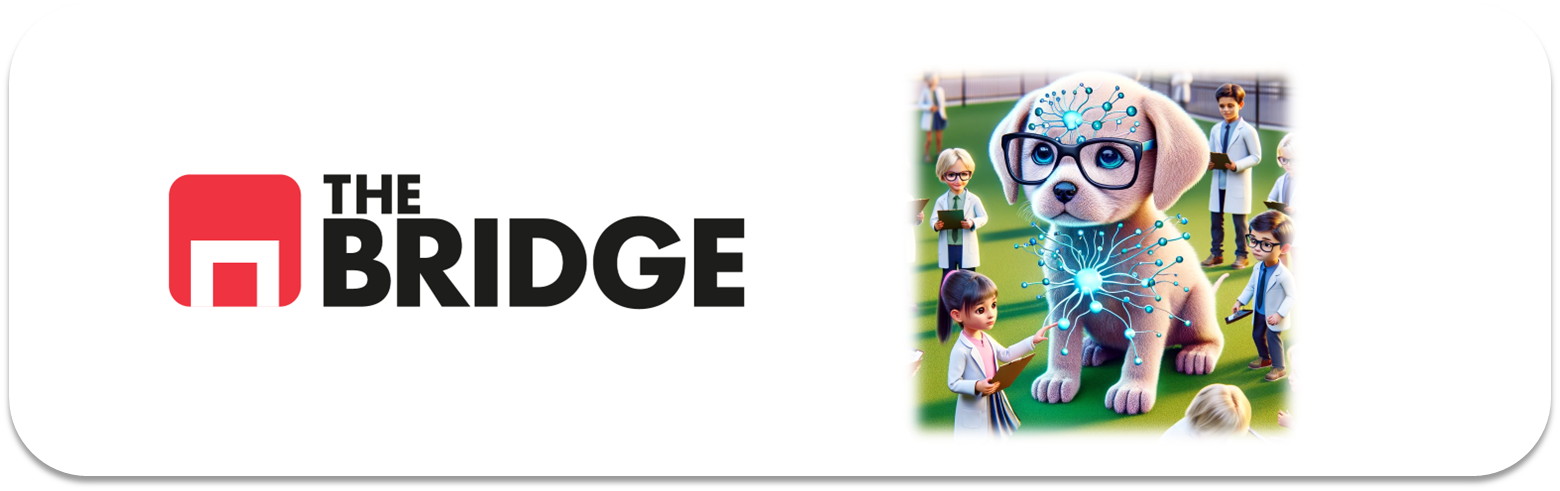

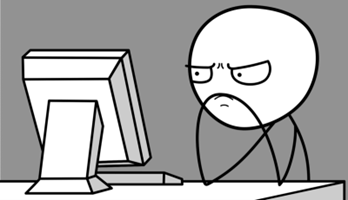

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [42]:
import pandas as pd

df = pd.read_csv('./data/air_pollution_new_city.csv', sep = '|')
df.head()
# Información del dataset
print(df.info())

# Comprobar valores nulos
print(df.isnull().sum())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
None
No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64


### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [43]:
# Convertir a datetime
df["datetime"] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])




In [44]:

# Establecer como índice
df_indexed = df.set_index("datetime").drop(columns=["No", "year", "month", "day", "hour"])




In [45]:
# Renombrar columnas
df_indexed.rename(columns={
    "pm2.5": "PM25",
    "DEWP": "Dew_Point",
    "TEMP": "Temperature",
    "PRES": "Pressure",
    "cbwd": "Wind_Direction",
    "Iws": "Wind_Speed",
    "Is": "Snow_Hours",
    "Ir": "Rain_Hours"
}, inplace=True)

# Mostrar el resultado
print(df_indexed.head())


                      PM25  Dew_Point  Temperature  Pressure Wind_Direction  \
datetime                                                                      
2019-01-02 00:00:00  129.0        -16         -4.0    1020.0             SE   
2019-01-02 01:00:00  148.0        -15         -4.0    1020.0             SE   
2019-01-02 02:00:00  159.0        -11         -5.0    1021.0             SE   
2019-01-02 03:00:00  181.0         -7         -5.0    1022.0             SE   
2019-01-02 04:00:00  138.0         -7         -5.0    1022.0             SE   

                     Wind_Speed  Snow_Hours  Rain_Hours  
datetime                                                 
2019-01-02 00:00:00        1.79           0           0  
2019-01-02 01:00:00        2.68           0           0  
2019-01-02 02:00:00        3.57           0           0  
2019-01-02 03:00:00        5.36           1           0  
2019-01-02 04:00:00        6.25           2           0  


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [46]:
# Ordenar el índice para evitar problemas con la selección de fechas
df_indexed = df_indexed.sort_index()

# Comprobar el rango de fechas disponibles
print(df_indexed.index.min(), df_indexed.index.max())

# Ahora separar el dataset
train = df_indexed.loc["2019-01-01":"2022-12-31"]
test = df_indexed.loc["2023-01-01":]

# Verificar si las divisiones fueron exitosas
print(train.shape, test.shape)




2019-01-02 00:00:00 2023-12-31 23:00:00
(35040, 8) (8760, 8)


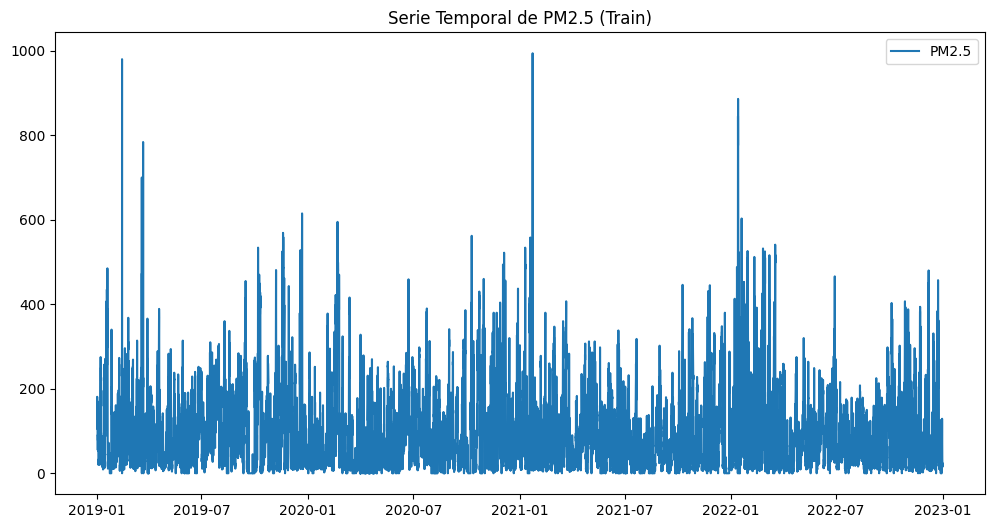

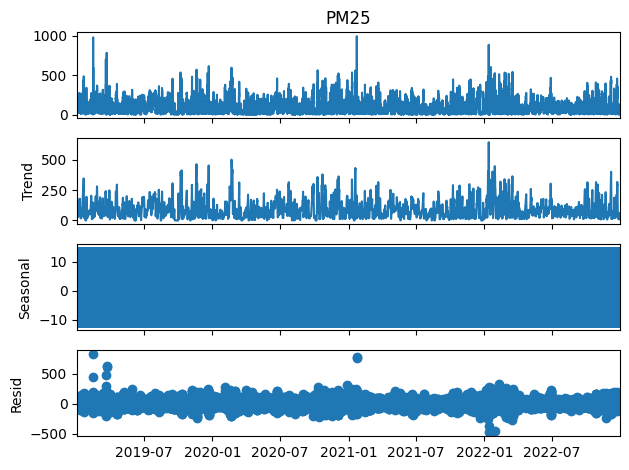

In [47]:

# Visualizar PM2.5 en el periodo de entrenamiento
plt.figure(figsize=(12,6))
plt.plot(train.index, train["PM25"], label="PM2.5")
plt.legend()
plt.title("Serie Temporal de PM2.5 (Train)")
plt.show()

# Descomposición aditiva
decomposition = seasonal_decompose(train["PM25"].interpolate(), model="additive", period=24)
decomposition.plot()
plt.show()




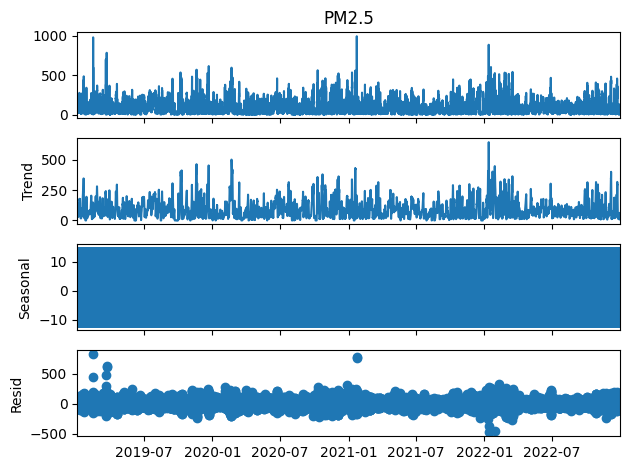

In [48]:



from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_data['PM2.5'], model='additive')
decomposition.plot()
plt.show()


### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

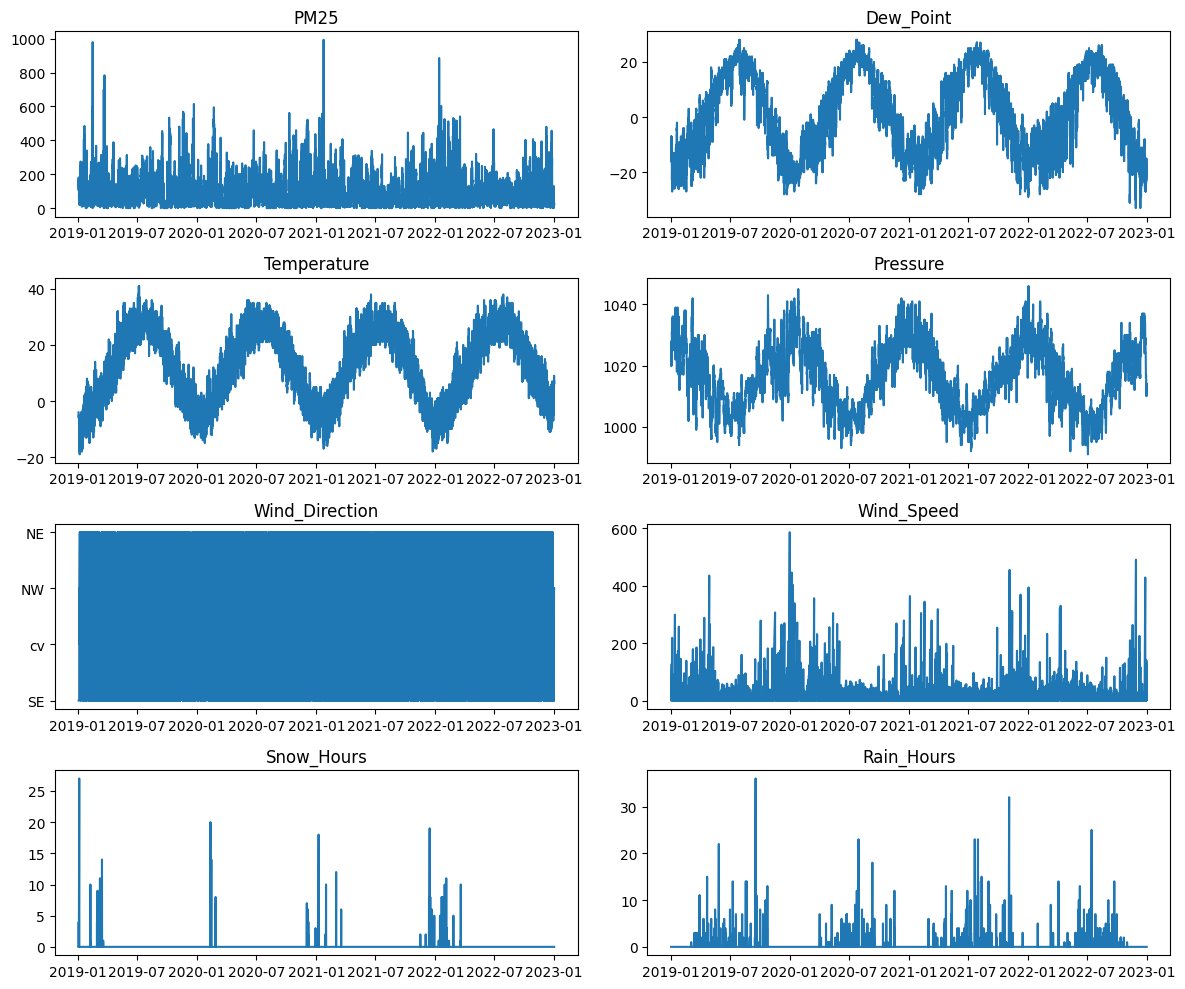

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

for i, column in enumerate(train.columns):
    ax = axes[i//2, i%2]
    ax.plot(train.index, train[column])
    ax.set_title(column)

plt.tight_layout()
plt.show()


### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [50]:
# Revisar nombres de columnas para verificar si "Wind_Direction" existe
print(df_indexed.columns)

# Si el nombre es diferente, ajustarlo
column_name = "Wind_Direction"  # Nombre correcto basado en la descripción inicial

# Aplicar one-hot encoding
df_indexed = pd.get_dummies(df_indexed, columns=[column_name])

# Convertir todos los valores a float32
df_indexed = df_indexed.astype("float32")



Index(['PM25', 'Dew_Point', 'Temperature', 'Pressure', 'Wind_Direction',
       'Wind_Speed', 'Snow_Hours', 'Rain_Hours'],
      dtype='object')


In [51]:
import numpy as np

def create_sequences(data, input_length=48, output_length=12):
    X, y = [], []
    for i in range(len(data) - input_length - output_length):
        X.append(data[i: i + input_length])
        y.append(data[i + input_length: i + input_length + output_length, 0])
    return np.array(X), np.array(y)

data_values = df_indexed.values
X, y = create_sequences(data_values)



### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X[:-3000].reshape(-1, X.shape[-1])).reshape(X[:-3000].shape)
y_train = scaler_y.fit_transform(y[:-3000])

X_val = scaler_x.transform(X[-3000:-1000].reshape(-1, X.shape[-1])).reshape(X[-3000:-1000].shape)
y_val = scaler_y.transform(y[-3000:-1000])

X_test = scaler_x.transform(X[-1000:].reshape(-1, X.shape[-1])).reshape(X[-1000:].shape)
y_test = scaler_y.transform(y[-1000:])



### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model_rnn = Sequential([
    SimpleRNN(32, activation="relu", return_sequences=False, input_shape=(48, X.shape[2])),
    Dense(12)
])

model_rnn.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)



Epoch 1/10


c:\Users\conch\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1274/1274 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0141 - mae: 0.0781 - val_loss: 0.0033 - val_mae: 0.0382
Epoch 2/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0037 - mae: 0.0405 - val_loss: 0.0031 - val_mae: 0.0368
Epoch 3/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0036 - mae: 0.0389 - val_loss: 0.0031 - val_mae: 0.0371
Epoch 4/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0035 - mae: 0.0384 - val_loss: 0.0030 - val_mae: 0.0358
Epoch 5/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0035 - mae: 0.0382 - val_loss: 0.0030 - val_mae: 0.0354
Epoch 6/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0035 - mae: 0.0382 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 7/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0035 - mae: 0.0381 - val_loss: 0.0030 - val_mae: 0.0360
Epoch 8/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0034 - mae: 0.0375 - val_loss: 0.0034 - val_mae: 0.0374
Epoch 9/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/st

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [54]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    LSTM(32, activation="relu", return_sequences=False, input_shape=(48, X.shape[2])),
    Dense(12)
])

model_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0076 - mae: 0.0581 - val_loss: 0.0032 - val_mae: 0.0380
Epoch 2/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0036 - mae: 0.0398 - val_loss: 0.0029 - val_mae: 0.0362
Epoch 3/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0027 - val_mae: 0.0346
Epoch 4/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0034 - mae: 0.0377 - val_loss: 0.0027 - val_mae: 0.0339
Epoch 5/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0032 - mae: 0.0368 - val_loss: 0.0026 - val_mae: 0.0342
Epoch 6/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0032 - mae: 0.0363 - val_loss: 0.0026 - val_mae: 0.0336
Epoch 7/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0031 - mae: 0.0363 - val_loss: 0.0026 - val_mae: 0.0328
Epoch 8/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0031 - mae: 0.0359 - val_loss: 0.0026 - val_mae: 0.0334
Epoch 9/10
1274/1274 ━━━━━━━━━━━

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [55]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(32, activation="relu", return_sequences=False, input_shape=(48, X.shape[2])),
    Dense(12)
])

model_gru.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)



Epoch 1/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0067 - mae: 0.0554 - val_loss: 0.0031 - val_mae: 0.0373
Epoch 2/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0028 - val_mae: 0.0354
Epoch 3/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0035 - mae: 0.0381 - val_loss: 0.0030 - val_mae: 0.0373
Epoch 4/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0034 - mae: 0.0376 - val_loss: 0.0028 - val_mae: 0.0345
Epoch 5/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0033 - mae: 0.0371 - val_loss: 0.0027 - val_mae: 0.0342
Epoch 6/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0032 - mae: 0.0368 - val_loss: 0.0025 - val_mae: 0.0322
Epoch 7/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0032 - mae: 0.0361 - val_loss: 0.0028 - val_mae: 0.0348
Epoch 8/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0031 - mae: 0.0359 - val_loss: 0.0024 - val_mae: 0.0330
Epoch 9/10
1274/1274 ━━━

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_test, y_test, scaler_y):
    y_pred = scaler_y.inverse_transform(model.predict(X_test))
    y_real = scaler_y.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = np.mean(np.abs(y_real - y_pred))
    return rmse, mae

print("RNN:", evaluate_model(model_rnn, X_test, y_test, scaler_y))
print("LSTM:", evaluate_model(model_lstm, X_test, y_test, scaler_y))
print("GRU:", evaluate_model(model_gru, X_test, y_test, scaler_y))

#LSTM sería el mejor modelo: rmse = 70.87 y mae = 43.66

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RNN: (np.float64(75.7034716839327), np.float32(47.45545))
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM: (np.float64(70.87708054706401), np.float32(43.669655))
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU: (np.float64(73.82247167508515), np.float32(46.015427))
